### Discovery

In [2]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
import numpy as np
from catboost import Pool, cv, CatBoostClassifier
# import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


In [16]:
def get_misinfo(ls_outlinks, news_clf, misinfo_clf, bias_clf):
    if 'url_domain' not in ls_outlinks.columns:
        ls_outlinks['url_domain'] = ls_outlinks['url']
    # ls_outlinks['is_news'] = news_clf.predict(ls_outlinks.drop(columns='url'))
    ls_outlinks['is_news'] = np.logical_or(news_clf.predict(ls_outlinks.drop(columns=['url','url_domain'])),ls_outlinks['url'].str.contains('news')==True)

    # print(ls_outlinks.groupby('is_news').describe())
    ls_outlinks['is_misinfo'] = misinfo_clf.predict(ls_outlinks.drop(columns=['url','is_news','url_domain']))
    # print(ls_news_df.groupby('is_misinfo').describe())
    ls_outlinks['is_biased'] = bias_clf.predict(ls_outlinks.drop(columns=['url','is_news','is_misinfo','url_domain']))
    return ls_outlinks[['url','is_news','is_misinfo','is_biased']] # [ls_news_df['is_misinfo']==1]

def get_misinfo_scores(ls_outlinks, news_clf, misinfo_clf, bias_clf):
    if 'url_domain' not in ls_outlinks.columns:
        ls_outlinks['url_domain'] = ls_outlinks['url']
        
    # Get news scores
    ls_outlinks['news_score'] = news_clf.predict_proba(
        ls_outlinks.drop(columns=['url', 'url_domain'])
    )[:, 1]  # Get probability of the positive class
    ls_outlinks['is_news'] = np.logical_or(
        ls_outlinks['news_score'] > 0.5,  # Threshold for binary classification
        ls_outlinks['url'].str.contains('news') == True
    )

    # Get misinformation scores
    ls_outlinks['misinfo_score'] = misinfo_clf.predict_proba(
        ls_outlinks.drop(columns=['url', 'url_domain', 'is_news'])
    )[:, 1]

    # Get bias scores
    ls_outlinks['bias_score'] = bias_clf.predict_proba(
        ls_outlinks.drop(columns=['url', 'url_domain', 'is_news', 'misinfo_score', 'news_score'])
    )[:, 1]

    return ls_outlinks[['url', 'news_score', 'misinfo_score', 'bias_score', 'is_news']]


news_clf = CatBoostClassifier().load_model('../pretrained_models/model_news_10k_mbfc')
misinfo_clf = CatBoostClassifier().load_model('../pretrained_models/model_misinfo_mbfc')
bias_clf = CatBoostClassifier().load_model('../pretrained_models/model_bias_mbfc')

### Dredge Discovery on MBFC Sites

In [ ]:
keyphrase_df = pd.read_csv('../data/DredgeDiscoveryMBFC/keyphrases.csv')[['domain','Keyword']]
serp_results_df = pd.read_csv('../data/DredgeDiscoveryMBFC/serp_results.csv')[['qry','domain']]
serp_results_df.columns = ['Keyword','domain_discovered']
dredge_discovery_domains_df = pd.merge(keyphrase_df,serp_results_df,on='Keyword',how='inner')
dredge_discovery_domains = dredge_discovery_domains_df['domain_discovered'].unique()
dredge_seo_attributes = pd.read_csv('../data/DredgeDiscoveryMBFC/seo_attributes_discovered_urls.csv')
dredge_seo_attributes = dredge_seo_attributes[dredge_seo_attributes['url'].isin(dredge_discovery_domains)]
len(dredge_seo_attributes)

<ipython-input-32-6059b472ff24>:1: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  keyphrase_df = pd.read_csv('../data/DredgeDiscoveryMBFC/keyphrases.csv')[['domain','Keyword']]


6733

If this assert fails, SEO attributes must be pulled for the discovered domains:
* see [data collection script](https://github.com/CASOS-IDeaS-CMU/Detection-and-Discovery-of-Misinformation-Sources/tree/master/data_collection)
* add to the relevant attribute [dataset](../data/DredgeDiscoveryMBFC/seo_attributes_discovered_urls.csv)

In [ ]:
missing_domains = set(dredge_discovery_domains) - set(dredge_seo_attributes['url'].unique())
assert len(dredge_seo_attributes) == len(dredge_discovery_domains), f"Pull attributes for {missing_domains}"

AssertionError: Pull attributes for {nan, 'ww12.shoebattube.com'}

In [34]:
# drop MBFC sites from NewsSEO dataset: https://kilthub.cmu.edu/articles/dataset/Dataset_for_Detection_and_Discovery_of_Misinformation_Sources_using_Attributed_Webgraphs_/25174193/1
# this filters out known misinformation sites, so we only label those that are not already in the dataset
mbfc_domains = pd.read_csv('../data/seo_attributes_mbfc_urls.csv')['url']
dredge_seo_attributes_filtered = dredge_seo_attributes[~dredge_seo_attributes['url'].isin(mbfc_domains)]
print(len(dredge_seo_attributes_filtered))
test_df = get_misinfo_scores(dredge_seo_attributes_filtered, news_clf, misinfo_clf, bias_clf)
news_df = test_df[test_df['is_news']]
news_df.sort_values(['misinfo_score', 'bias_score'], ascending=False).head(20)['url'].to_csv('top20.csv', index=False)

6196


<ipython-input-16-42d534982ea9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ls_outlinks['url_domain'] = ls_outlinks['url']
<ipython-input-16-42d534982ea9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ls_outlinks['news_score'] = news_clf.predict_proba(
<ipython-input-16-42d534982ea9>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [38]:
test_df = get_misinfo(dredge_seo_attributes_filtered, news_clf, misinfo_clf, bias_clf, )#,'../data/ls_outlinks.csv')#'common_crawl_small_sample.csv')
discovered_misinfo_full = test_df.query('is_misinfo == 1 & is_biased == 1')
discovered_misinfo_full.describe()

<ipython-input-16-42d534982ea9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ls_outlinks['is_news'] = np.logical_or(news_clf.predict(ls_outlinks.drop(columns=['url','url_domain'])),ls_outlinks['url'].str.contains('news')==True)
<ipython-input-16-42d534982ea9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ls_outlinks['is_misinfo'] = misinfo_clf.predict(ls_outlinks.drop(columns=['url','is_news','url_domain']))
<ipython-input-16-42d534982ea9>:10: SettingWithCopyWarning: 
A value is trying to be set on a

,is_misinfo,is_biased
count,2809.0,2809.0
mean,1.0,1.0
std,0.0,0.0
min,1.0,1.0
25%,1.0,1.0
50%,1.0,1.0
75%,1.0,1.0
max,1.0,1.0


### Dredge Discovery on Politifact Sites (Partial F1 Metrics)

In [130]:
politifact_keyphrase_df = pd.read_csv('../data/DredgeDiscoveryPolitifact/keyphrases.csv', encoding='latin-1')
politifact_keyphrase_df['domain'] = politifact_keyphrase_df['Current URL'].str.replace('https://','').str.replace('http://','').str.replace('www.','').str.split('/').str[0]
politifact_keyphrase_df = politifact_keyphrase_df[['domain','Keyword']]
politifact_serp_results_df = pd.read_csv('../data/DredgeDiscoveryPolitifact/serp_results.csv')[['qry','url']]
politifact_serp_results_df['url'] = politifact_serp_results_df['url'].str.replace('https://','').str.replace('http://','').str.replace('www.','').str.split('/').str[0]
politifact_serp_results_df.columns = ['Keyword','domain_discovered']
# politifact_discovery_domains_df = pd.merge(politifact_keyphrase_df,politifact_serp_results_df,on='Keyword',how='inner')
politifact_discovery_domains = politifact_serp_results_df['domain_discovered'].unique()

politifact_discovered_attributes = pd.read_csv('../data/DredgeDiscoveryPolitifact/seo_attributes_discovered_urls.csv')
politifact_discovered_attributes = politifact_discovered_attributes[politifact_discovered_attributes['url'].isin(politifact_discovery_domains)]
len(politifact_discovered_attributes)

7002

If this assert fails, SEO attributes must be pulled for the discovered domains:
* see [data collection script](https://github.com/CASOS-IDeaS-CMU/Detection-and-Discovery-of-Misinformation-Sources/tree/master/data_collection)
* add to the relevant attribute [dataset](../data/DredgeDiscoveryPolitifact/seo_attributes_discovered_urls.csv)

In [131]:
missing_domains = set(politifact_discovery_domains) - set(politifact_discovered_attributes['url'].unique())
assert len(missing_domains) == 0, f"Pull attributes for {missing_domains}"

AssertionError: Pull attributes for {nan, '', 'ncwb.uscourts.gov', 'ncdhhs.gov', 'indianaautismalliance.org', 'jewishsantabarbara.org', 'markusproducts.com', 'alternativecolognetours.com', 'ftp:'}

In [ ]:
# Double checking that all politifact serp results are from politifact list
politifact_serp_results_df = pd.read_csv('../data/DredgeDiscoveryPolitifact/serp_results.csv')[['qry','url','domain']]
pf_domains = pd.read_csv('../data/PoliticalNewsDataset/domains.csv')
pf_domains = pf_domains[pf_domains[" fake"] == 1]
kp_domains = politifact_serp_results_df['domain'].unique()
# count overlap
overlap = len(set(kp_domains).intersection(set(pf_domains['url'])))
print(len(pf_domains))
print(len(kp_domains))
print(overlap)

79
21
21


In [134]:
test_df = get_misinfo(politifact_discovered_attributes, news_clf, misinfo_clf, bias_clf)
politifact_discovered_misinfo = test_df.query('is_news == 1 & is_misinfo == 1 & is_biased == 1')
politifact_discovered_misinfo.describe()
# discovered_misinfo_full.sample(50).to_csv("serp_discovery_results_sample.csv",index=False)

,is_misinfo,is_biased
count,392.0,392.0
mean,1.0,1.0
std,0.0,0.0
min,1.0,1.0
25%,1.0,1.0
50%,1.0,1.0
75%,1.0,1.0
max,1.0,1.0


In [135]:
def compute_partial_f1(actual_domains, predicted_domains):
    # Calculate partial true positive (pTP)
    pTP = len(set(predicted_domains) & set(actual_domains))
    
    # Calculate partial false positive (pFP)
    pFP = len(set(predicted_domains) - set(actual_domains))
    
    # Calculate partial false negative (pFN)
    pFN = len(set(actual_domains) - set(predicted_domains))
    
    # Calculate partial precision (pP)
    if pTP + pFP > 0:
        pP = pTP / (pTP + pFP)
    else:
        pP = 0.0
    
    # Calculate partial recall (pR)
    if pTP + pFN > 0:
        pR = pTP / (pTP + pFN)
    else:
        pR = 0.0
    
    # Calculate partial F1 score (pF1)
    if pP + pR > 0:
        pF1 = 2 * ((pP * pR) / (pP + pR))
    else:
        pF1 = 0.0
    
    return {'Partial F1': pF1, 'Partial Precision':pP, 'Partial Recall': pR}

df_mbfc_full = pd.read_csv('../data/seo_attributes_mbfc_urls.csv')
df_mbfc = df_mbfc_full[df_mbfc_full['source'].str.contains('MBFC')]
df_mbfc = df_mbfc[df_mbfc['label']<=4]
print("Dredge discovery on Politifact URLs: \n", compute_partial_f1(df_mbfc['url'], politifact_discovered_misinfo['url']))
# print("Dredge discovery on full MBFC URLs: \n", compute_partial_f1(df_mbfc['url'], dredge_discovery_domains))

Dredge discovery on Politifact URLs: 
 {'Partial F1': 0.11397557666214382, 'Partial Precision': 0.21428571428571427, 'Partial Recall': 0.07763401109057301}


### GNN Discovery
Here we take reliability predictions on unlabeled nodes in the GNN, and show how partial F1, recall and precision metrics relate to model confidence.

In [ ]:
import pandas as pd

discovered_urls = pd.read_csv("../data/GNNDiscovery/polit_gnn_preds.csv")[['nodes','confidence','preds']]

def flip_conf(row):
    if row['preds'] == 1:
        row['confidence'] = 1 - row['confidence']
    return row

discovered_urls = discovered_urls.apply(flip_conf, axis=1)
# discovered_urls = discovered_urls[discovered_urls['preds']==0]

discovered_urls.columns=['url','confidence','preds']
results = []
thresholds = np.arange(0, 1, 0.05)
for threshold in thresholds:
    res = compute_partial_f1(df_mbfc['url'], discovered_urls[discovered_urls['confidence']>threshold]['url'])
    res['threshold'] = threshold
    results.append(res)
    print ("{:<10} {:<10} {:<10} {:<10}".format(round(threshold, 2), 
        round(res['Partial F1'], 2), round(res['Partial Precision'], 2), round(res['Partial Recall'], 2)))


# res_df.to_csv(res_name, index=False)

0.0        0.19       0.12       0.41      
0.05       0.19       0.12       0.41      
0.1        0.19       0.13       0.41      
0.15       0.2        0.13       0.4       
0.2        0.2        0.13       0.4       
0.25       0.2        0.14       0.4       
0.3        0.2        0.14       0.4       
0.35       0.21       0.14       0.39      
0.4        0.21       0.15       0.39      
0.45       0.22       0.16       0.38      
0.5        0.23       0.17       0.37      
0.55       0.24       0.18       0.35      
0.6        0.24       0.19       0.32      
0.65       0.24       0.21       0.28      
0.7        0.23       0.23       0.23      
0.75       0.19       0.23       0.16      
0.8        0.13       0.24       0.09      
0.85       0.07       0.24       0.04      
0.9        0.02       0.17       0.01      
0.95       0.0        0.0        0.0       


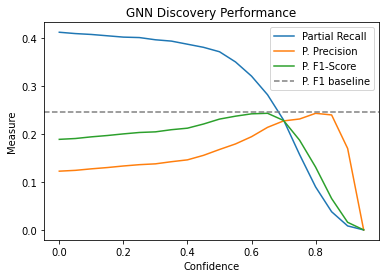

In [110]:
res_df = pd.DataFrame(results, index=None)
res_df.columns = ['F1', 'P', 'R', 'Confidence']
sns.lineplot(data=res_df, x='Confidence', y='R', label='Partial Recall')
sns.lineplot(data=res_df, x='Confidence', y='P', label='P. Precision')
sns.lineplot(data=res_df, x='Confidence', y='F1', label='P. F1-Score')
plt.axhline(y=0.245, color='gray', linestyle='--', label='P. F1 baseline')
plt.legend(loc='upper right')
plt.title('GNN Discovery Performance')
plt.ylabel('Measure')
plt.savefig('discovery_performance_sm_seo.png', dpi=300, bbox_inches='tight')